# Modelos para la predicción de precipitaciones en la estación de Retiro

**Este notebook pertenece al Trabajo Fin de Grado del Curso de Adaptación al Grado de Ingeniería en Informática**


*Fecha:* Junio 2022

*Autor:* Ruth Lospitao Ruiz


*Email:* rlospitao@gmail.com

## Introducción

El **objetivo** de este libro es hacer la predicción de la precipitación máxima que se va a producir en el siguiente mes, teniendo en cuenta los doce meses anteriores.

Para ello, se comenzará preparando los datos y realizando una primera aproximación base para ir analizando diferentes modelos que proporcionen un mejor resultado.

Los modelos realizados son:


* Modelo simple de Redes Neuronales Recurrentes LSTM
* Modelo Red Neuronal Recurrente (dropout-regularized)
* Modelo Red Neuronal Recurrente con GRU
* Modelo Red Neuronal LSTM Bidireccional



##  Preparación de los datos

En primer lugar, se cargan los datos climatológicos de la estación de Retiro; los cuales, previamente, han sido tratados *(fichero "data_clean_3195.csv")*

In [1]:
file = open("data/data_clean_3195.csv", "r") 

lines = [line.rstrip('\n') for line in file]
header = lines[0].split(',')
lines = lines[1:]

import numpy as np
precipitation = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))


for i, line in enumerate(lines):
    values = [float(x) if len(x) else 0.0 for x in line.split(',')[1:]]
    precipitation[i] = values[1]    
    raw_data[i, :] = values[:]


A continuación, se muestran los datos gráficamente. Se puede observar que se tiene una serie

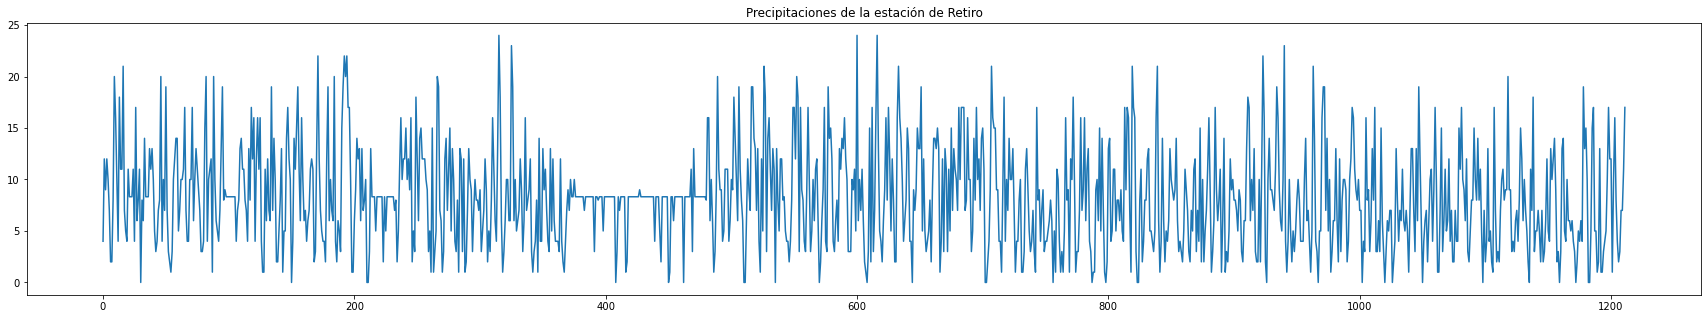

In [2]:
from matplotlib import pyplot as plt
plt.figure(figsize=(30,5))
plt.title("Precipitaciones de la estación de Retiro")
plt.plot(range(len(precipitation)), precipitation)

Se estable el **tamaño de los tres subconjuntos de datos** en los que se dividirá el conjunto de datos (o dataset):
* el **conjunto de datos de entrenamiento (*training*)**, serán los datos que se utilizarán para entrenar al modelo. Se establece el 80%
* el **conjunto de datos de validación (*val*)**, que son los datos que sirven de apoyo durante el entrenamiento. Se establece el 10%
* el **conjunto de datos de prueba (*test*)**, es el conjunto de datos sobre el cual se va a aplicar el modelo una vez que ha sido entrenado. Se establece el 10%

In [3]:
num_train_samples = int(0.8 * len(raw_data))
num_val_samples = int(0.10 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("Nº de muestras para el entrenamiento (num_train_samples):", num_train_samples)
print("Nº de muestras para validación (num_val_samples):", num_val_samples)
print("Nº de muestras para test (num_test_samples):", num_test_samples)

Nº de muestras para el entrenamiento (num_train_samples): 969
Nº de muestras para validación (num_val_samples): 121
Nº de muestras para test (num_test_samples): 122



El siguiente paso será **normalizar los datos** del conjunto de entrenamiento.



In [4]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Se **preparan los subconjuntos de datos**, los cuales están basados en series temporales:

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [6]:
sampling_rate = 1 # 
sequence_length = 12 # 12 meses para un año
delay = sampling_rate * sequence_length
batch_size = 1

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=precipitation[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=precipitation[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=precipitation[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [7]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (1, 12, 25)
targets shape: (1,)


## Sin aprendizaje automático: línea base MAE

Se calcula el error absoluto medio (MAE), el cual representa la diferencia entre los valores originales y los predichos extraído mediante el promedio de la diferencia absoluta sobre el conjunto de datos.

In [8]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 4.60
Test MAE: 4.22


## Modelo simple de Redes Neuronales Recurrente (LSTM)



Mientras las redes recurrentes estándar pueden modelar dependencias a corto plazo (es decir, relaciones cercanas en la serie cronológica), las LSTM pueden aprender dependencias largas, por lo que se podría decir que tienen una «memoria» a más largo plazo.
A continuacuon, se prueba un modelo básico de RNN LSTM

<b> Caso 1: epochs=25 y optimizer="rmsprop"</b>

In [9]:
# 1. Definiendo la arquitectura de la red

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(28)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_lstm_rmsprop25.keras",
                                    save_best_only=True)
]

# 2. Compilación de la red
model.compile(optimizer="rmsprop", loss="mae", metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("precipitation_lstm_rmsprop25.keras")

#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
958/958 [==============================] - 10s 8ms/step - loss: 4.0539 - mae: 4.0539 - val_loss: 3.4147 - val_mae: 3.4147
Epoch 2/25
958/958 [==============================] - 8s 8ms/step - loss: 3.6218 - mae: 3.6218 - val_loss: 3.3933 - val_mae: 3.3933
Epoch 3/25
958/958 [==============================] - 8s 8ms/step - loss: 3.4839 - mae: 3.4839 - val_loss: 3.3060 - val_mae: 3.3060
Epoch 4/25
958/958 [==============================] - 8s 8ms/step - loss: 3.4068 - mae: 3.4068 - val_loss: 3.2985 - val_mae: 3.2985
Epoch 5/25
958/958 [==============================] - 8s 8ms/step - loss: 3.3440 - mae: 3.3440 - val_loss: 3.3532 - val_mae: 3.3532
Epoch 6/25
958/958 [==============================] - 8s 8ms/step - loss: 3.2936 - mae: 3.2936 - val_loss: 3.3922 - val_mae: 3.3922
Epoch 7/25
958/958 [==============================] - 8s 8ms/step - loss: 3.2083 - mae: 3.2083 - val_loss: 3.5003 - val_mae: 3.5003
Epoch 8/25
958/958 [==============================] - 9s 9ms/step - loss: 3

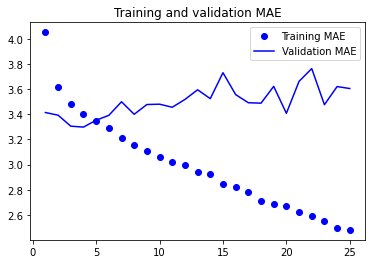

In [10]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

<b> Caso 2: epochs=25 y optimizer="adam"</b>

In [11]:
# 1. Definiendo la arquitectura de la red
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(28)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_lstm_adam25.keras",
                                    save_best_only=True)
]
# 2. Compilación de la red
model.compile(optimizer="adam", loss="mae" , metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("precipitation_lstm_adam25.keras")

#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
958/958 [==============================] - 12s 9ms/step - loss: 4.0705 - mae: 4.0705 - val_loss: 3.3065 - val_mae: 3.3065
Epoch 2/25
958/958 [==============================] - 9s 9ms/step - loss: 3.5390 - mae: 3.5390 - val_loss: 3.2109 - val_mae: 3.2109
Epoch 3/25
958/958 [==============================] - 9s 9ms/step - loss: 3.4248 - mae: 3.4248 - val_loss: 3.1906 - val_mae: 3.1906
Epoch 4/25
958/958 [==============================] - 10s 10ms/step - loss: 3.3511 - mae: 3.3511 - val_loss: 3.1594 - val_mae: 3.1594
Epoch 5/25
958/958 [==============================] - 13s 13ms/step - loss: 3.2934 - mae: 3.2934 - val_loss: 3.2383 - val_mae: 3.2383
Epoch 6/25
958/958 [==============================] - 13s 14ms/step - loss: 3.2179 - mae: 3.2179 - val_loss: 3.1341 - val_mae: 3.1341
Epoch 7/25
958/958 [==============================] - 12s 12ms/step - loss: 3.1602 - mae: 3.1602 - val_loss: 3.1400 - val_mae: 3.1400
Epoch 8/25
958/958 [==============================] - 10s 11ms/step

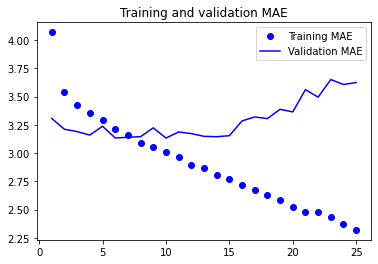

In [12]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Modelo Redes Neuronales Recurrentes LSTM (dropout-regularized)

Entrenando y evaluando LSTM (dropout-regularized). El dropout es un método de regularización en el que las conexiones de entrada y recurrentes a las unidades LSTM se excluyen probabilísticamente de las actualizaciones de activación y peso mientras se entrena una red. Esto tiene el efecto de reducir el sobreajuste y mejorar el rendimiento del modelo

<b> Caso 1: epochs=25 optimizer="rmsprop" </b>

In [13]:
# 1. Definiendo la arquitectura de la red
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(56, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_lstm_dropout_rmsprop25.keras",
                                    save_best_only=True)
]
# 2. Compilación de la red
model.compile(optimizer="rmsprop", loss="mae", metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("precipitation_lstm_dropout_rmsprop25.keras")

#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/25
958/958 [==============================] - 20s 18ms/step - loss: 4.0843 - mae: 4.0843 - val_loss: 3.4055 - val_mae: 3.4055
Epoch 2/25
958/958 [==============================] - 16s 17ms/step - loss: 3.7106 - mae: 3.7106 - val_loss: 3.2679 - val_mae: 3.2679
Epoch 3/25
958/958 [==============================] - 15s 16ms/step - loss: 3.6798 - mae: 3.6798 - val_loss: 3.2139 - val_mae: 3.2139
Epoch 4/25
958/958 [==============================] - 16s 17ms/step - loss: 3.6426 - mae: 3.6426 - val_loss: 3.1919 - val_mae: 3.1919
Epoch 5/25
958/958 [==============================] - 17s 18ms/step - loss: 3.5352 - mae: 3.5352 - val_loss: 3.2474 - val_mae: 3.2474
Epoch 6/25
958/958 [==============================] - 20s 21ms/step - loss: 3.4548 - mae: 3.4548 - val_loss: 3.3551 - val_mae: 3.3551
Epoch 7/25
958/958 [==============================] - 24s 25ms/step - loss: 3.4533 - mae: 3.4533 - val_loss: 3.2562 - val_mae: 3.2562
Epoch 8/25
958/958 [==============================] - 20s 21ms

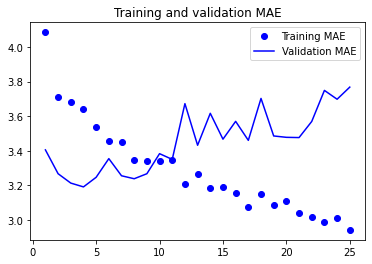

In [14]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

<b> Caso 2: epochs=25 optimizer="adam" </b>

In [15]:
# 1. Definiendo la arquitectura de la red
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(56, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_lstm_dropout_adam25.keras",
                                    save_best_only=True)
]
# 2. Compilación de la red
model.compile(optimizer="adam", loss="mae", metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("precipitation_lstm_dropout_adam25.keras")
#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
958/958 [==============================] - 27s 25ms/step - loss: 4.0770 - mae: 4.0770 - val_loss: 3.4891 - val_mae: 3.4891
Epoch 2/25
958/958 [==============================] - 21s 22ms/step - loss: 3.6813 - mae: 3.6813 - val_loss: 3.2212 - val_mae: 3.2212
Epoch 3/25
958/958 [==============================] - 18s 18ms/step - loss: 3.5960 - mae: 3.5960 - val_loss: 3.1587 - val_mae: 3.1587
Epoch 4/25
958/958 [==============================] - 17s 17ms/step - loss: 3.5624 - mae: 3.5624 - val_loss: 3.1625 - val_mae: 3.1625
Epoch 5/25
958/958 [==============================] - 17s 18ms/step - loss: 3.4138 - mae: 3.4138 - val_loss: 3.2452 - val_mae: 3.2452
Epoch 6/25
958/958 [==============================] - 19s 20ms/step - loss: 3.4430 - mae: 3.4430 - val_loss: 3.3344 - val_mae: 3.3344
Epoch 7/25
958/958 [==============================] - 24s 25ms/step - loss: 3.4317 - mae: 3.4317 - val_loss: 3.2089 - val_mae: 3.2089
Epoch 8/25
958/958 [==============================] - 22s 23ms

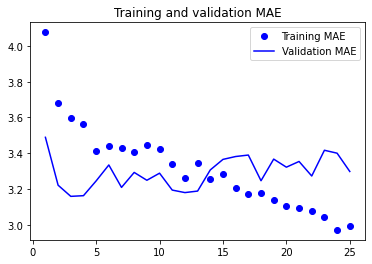

In [16]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Modelo Redes Neuronales Recurrentes con GRU 


Las GRUs son neuronas recurrentes con una estructura algo diferente que las LSTM. Son más nuevas y eliminan algunas de las operaciones de las LSTM.
A efectos prácticos las dos morfologías de red funcionan bien. Cual es mejor dependerá del tipo de problema y, por consiguiente, lo más recomendable es probar las 2 arquitecturas.

<b> Caso 1: epochs=25 optimizer="rmsprop" </b>

In [17]:
# 1. Definiendo la arquitectura de la red
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(56, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(56, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_stacked_gru_dropout_rmsprop25.keras",
                                    save_best_only=True)
]
# 2. Compilación de la red
model.compile(optimizer="rmsprop", loss="mae", metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("precipitation_stacked_gru_dropout_rmsprop25.keras")
#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/25
958/958 [==============================] - 42s 38ms/step - loss: 4.0703 - mae: 4.0703 - val_loss: 3.2119 - val_mae: 3.2119
Epoch 2/25
958/958 [==============================] - 43s 45ms/step - loss: 3.7080 - mae: 3.7080 - val_loss: 3.1227 - val_mae: 3.1227
Epoch 3/25
958/958 [==============================] - 38s 40ms/step - loss: 3.5909 - mae: 3.5909 - val_loss: 3.1398 - val_mae: 3.1398
Epoch 4/25
958/958 [==============================] - 39s 40ms/step - loss: 3.6387 - mae: 3.6387 - val_loss: 3.2055 - val_mae: 3.2055
Epoch 5/25
958/958 [==============================] - 43s 45ms/step - loss: 3.4975 - mae: 3.4975 - val_loss: 3.1745 - val_mae: 3.1745
Epoch 6/25
958/958 [==============================] - 35s 37ms/step - loss: 3.4736 - mae: 3.4736 - val_loss: 3.2894 - val_mae: 3.2894
Epoch 7/25
958/958 [==============================] - 47s 49ms/step - loss: 3.4293 - mae: 3.4293 - val_loss: 3.2271 - val_mae: 3.2271
Epoch 8/25
958/958 [==============================] - 37s 39ms

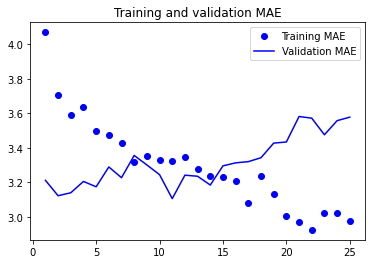

In [18]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

<b> Caso 2: epochs=25 optimizer="adam" </b>

In [19]:
# 1. Definiendo la arquitectura de la red
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(56, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(56, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_stacked_gru_dropout_adam25.keras",
                                    save_best_only=True)
]
# 2. Compilación de la red
model.compile(optimizer="adam", loss="mae", metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("precipitation_stacked_gru_dropout_adam25.keras")
#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
958/958 [==============================] - 43s 38ms/step - loss: 3.9723 - mae: 3.9723 - val_loss: 3.2172 - val_mae: 3.2172
Epoch 2/25
958/958 [==============================] - 43s 44ms/step - loss: 3.7076 - mae: 3.7076 - val_loss: 3.1658 - val_mae: 3.1658
Epoch 3/25
958/958 [==============================] - 42s 44ms/step - loss: 3.5871 - mae: 3.5871 - val_loss: 3.1696 - val_mae: 3.1696
Epoch 4/25
958/958 [==============================] - 38s 40ms/step - loss: 3.5269 - mae: 3.5269 - val_loss: 3.2448 - val_mae: 3.2448
Epoch 5/25
958/958 [==============================] - 44s 46ms/step - loss: 3.5193 - mae: 3.5193 - val_loss: 3.1723 - val_mae: 3.1723
Epoch 6/25
958/958 [==============================] - 35s 37ms/step - loss: 3.5408 - mae: 3.5408 - val_loss: 3.1680 - val_mae: 3.1680
Epoch 7/25
958/958 [==============================] - 45s 46ms/step - loss: 3.4476 - mae: 3.4476 - val_loss: 3.1765 - val_mae: 3.1765
Epoch 8/25
958/958 [==============================] - 42s 43ms

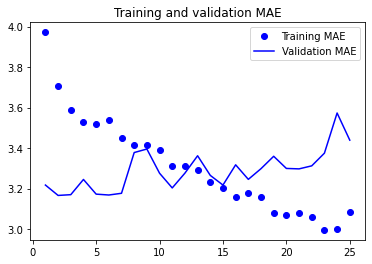

In [20]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Modelo Redes Neuronales LSTM bidireccional

<b> Caso 1: epochs=25 optimizer="rmsprop" </b>

In [21]:
# 1. Definiendo la arquitectura de la red
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(28))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_bidir_lstm_rmsprop25.keras",
                                    save_best_only=True)
]
# 2. Compilación de la red
model.compile(optimizer="rmsprop", loss="mae", metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("precipitation_bidir_lstm_rmsprop25.keras")
#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
958/958 [==============================] - 25s 19ms/step - loss: 3.9207 - mae: 3.9207 - val_loss: 3.2633 - val_mae: 3.2633
Epoch 2/25
958/958 [==============================] - 14s 15ms/step - loss: 3.4461 - mae: 3.4461 - val_loss: 3.1982 - val_mae: 3.1982
Epoch 3/25
958/958 [==============================] - 16s 16ms/step - loss: 3.3641 - mae: 3.3641 - val_loss: 3.1863 - val_mae: 3.1863
Epoch 4/25
958/958 [==============================] - 14s 14ms/step - loss: 3.2915 - mae: 3.2915 - val_loss: 3.1674 - val_mae: 3.1674
Epoch 5/25
958/958 [==============================] - 15s 15ms/step - loss: 3.2139 - mae: 3.2139 - val_loss: 3.1924 - val_mae: 3.1924
Epoch 6/25
958/958 [==============================] - 18s 19ms/step - loss: 3.1620 - mae: 3.1620 - val_loss: 3.2316 - val_mae: 3.2316
Epoch 7/25
958/958 [==============================] - 17s 17ms/step - loss: 3.0907 - mae: 3.0907 - val_loss: 3.1950 - val_mae: 3.1950
Epoch 8/25
958/958 [==============================] - 15s 16ms

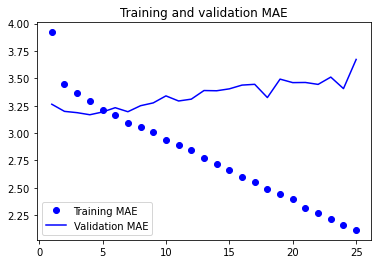

In [22]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

<b> Caso 2: epochs=25 optimizer="adam" </b>

In [23]:
# 1. Definiendo la arquitectura de la red
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(28))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("precipitation_bidir_lstm_adam25.keras",
                                    save_best_only=True)
]
# 2. Compilación de la red
model.compile(optimizer="adam", loss="mae", metrics=["mae"])

#3. Entrenamiento
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("precipitation_bidir_lstm_adam25.keras")
#4. Evaluación del modelo
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
958/958 [==============================] - 24s 19ms/step - loss: 3.9435 - mae: 3.9435 - val_loss: 3.2460 - val_mae: 3.2460
Epoch 2/25
958/958 [==============================] - 16s 17ms/step - loss: 3.4153 - mae: 3.4153 - val_loss: 3.1734 - val_mae: 3.1734
Epoch 3/25
958/958 [==============================] - 13s 14ms/step - loss: 3.3183 - mae: 3.3183 - val_loss: 3.1894 - val_mae: 3.1894
Epoch 4/25
958/958 [==============================] - 13s 14ms/step - loss: 3.2398 - mae: 3.2398 - val_loss: 3.1772 - val_mae: 3.1772
Epoch 5/25
958/958 [==============================] - 16s 17ms/step - loss: 3.1703 - mae: 3.1703 - val_loss: 3.1719 - val_mae: 3.1719
Epoch 6/25
958/958 [==============================] - 19s 20ms/step - loss: 3.0774 - mae: 3.0774 - val_loss: 3.2050 - val_mae: 3.2050
Epoch 7/25
958/958 [==============================] - 22s 22ms/step - loss: 3.0016 - mae: 3.0016 - val_loss: 3.2265 - val_mae: 3.2265
Epoch 8/25
958/958 [==============================] - 15s 16ms

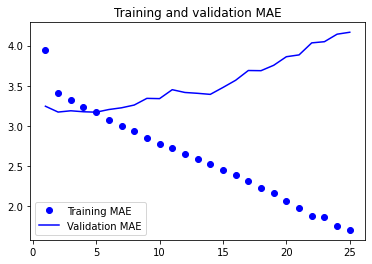

In [24]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Conclusiones

De las cuatro arquitecturas de redes neuronales recurrentes probadas se han obtenido los siguientes valores MAE:

<table>
	<thead>
		<tr>
			<th>Modelo</th>
			<th>Función de optmización</th>
			<th>Test MAE</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td rowspan=2>Modelo simple RNR LSTM</td>
			<td>rmsprop</td>
			<td>3.59</td>
		</tr>
		<tr>
			<td>adam</td>
			<td>3.36</td>
			<td></td>
		</tr>
		<tr>
			<td rowspan=2>Modelo  RNR LSTM Dropout</td>
			<td>rmsprop</td>
			<td>3.60</td>
		</tr>
		<tr>
			<td>adam</td>
			<td>3.41</td>
			<td></td>
		</tr>
		<tr>
			<td rowspan=2>Modelo  RNR LSTM Gru</td>
			<td>rmsprop</td>
			<td>3.54</td>
		</tr>
		<tr>
			<td>adam</td>
			<td>3.45</td>
			<td></td>
		</tr>
		<tr>
			<td rowspan=2>Modelo  RNR Bidireccional</td>
			<td>rmsprop</td>
			<td>3.51</td>
		</tr>
		<tr>
			<td>adam</td>
			<td>3.51</td>
		</tr>
	</tbody>
</table>

Por tanto, se concluye que el mejor modelo sería el correspondiente al modelo simple LSTM con la función de optimización "adam", para el cual se ha obtenido un valor de 3.47. 
No obstante, respecto a la línea base obtenida sin aprendizaje automático (MAE= 4.22), se puede concluir que este modelo mejora levemente los resultados, pero posiblemente con una mejor configuración de los parámetros se podrían mejorar el MAE.

# Exportación predicciones

Exportar predicciones a un fichero xlsx para, posteriormente, calcular el índice SPI y determinar si hay sequía o no.

In [25]:
prediccion = model.predict (test_dataset)


In [26]:
import pandas as pd

df_predicction = pd.DataFrame(prediccion)

df_predicction.to_excel("data/prediction_precipitation_3195.xlsx", index=False, header=True)